In [1]:
# _*_ coding: utf-8 _*_

import re
import nltk
import os
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from shutil import rmtree
from IPython.display import display
import pandas as pd

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aqaq9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def del_folder(path):
    try:
        rmtree(path)
    except:
        pass


In [10]:
BASE_DIR = "../../sample_articles"
ORIGIN_PATH = os.path.join(BASE_DIR,"Origin-Data")
PREPROCESSED_PATH = os.path.join(BASE_DIR,"Preprocessed-Data")
PRETTY_PATH = os.path.join(BASE_DIR,"Pretty-Data")
SWORDS_PATH = os.path.join(BASE_DIR, "StopWordList.txt")

In [11]:
class TextPreprocessor:
    def __init__(self):
        self.retokenize = RegexpTokenizer("[\w]+")
        self.swords = []
        self.tokenizer = {}

    def removeDuplicateSpace(self, text):
        return re.sub('\s+', ' ', text)  # 중복 공백, 탭, 개행 제거
    
    def removeSpecialChar(self, text):
        return ' '.join(self.retokenize.tokenize(text))


    def loadSwords(self, filename):
        self.swords = []
        with open(filename, 'r', encoding='utf-8') as f:
            swords = f.readlines()
            self.swords = [sword.strip() for sword in self.swords]

        self.tokenizer = lambda sent: filter(lambda x:x not in self.swords, sent.split())

        return self.swords
        
    def removeSwords(self, text):
        return ' '.join([token for token in list(self.tokenizer(text))]) 

In [12]:
def saveTextFile(baseDir, media, filename, sentences):

    mkdir_p(os.path.join(baseDir, media))
    save_path = os.path.join(os.path.join(baseDir, media), filename)

    with open(save_path, 'w', encoding='utf-8') as f:
        f.write('/n'.join([sentence for sentence in sentences if sentence is not '']))


In [13]:
class Article:
    def __init__(self, articleInfo):
        self.title = articleInfo[0]
        self.media = articleInfo[1]
        self.content = articleInfo[2:]

    def readContent(self):
        for line in self.content:
            if line is '': continue
            yield line            

In [14]:
class ArticleReader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.rgxSplitter = re.compile('([.!?:-](?:["\']|(?![0-9])))')
        self.content = ''

    def __iter__(self):
        def is_splited_sentence(sentences):
            return len(sentences) > 1
        
        with open(self.filepath, encoding='utf-8') as f:
            title = f.readline()[:-1]
            yield title
            self.content = f.readline()[:-1]

            media = f.readline()[:-1]
            yield media

            self.del_personal_info(media)
            docs = self.rgxSplitter.split(self.content)
            
            if not is_splited_sentence(docs): # 본문이 1줄이며, 위 정규식에 따라 split 되지 않음
                yield docs[0]
            else :
                for s in map(lambda a, b: a + b, docs[::2], docs[1::2]):
                    if not s: continue
                    yield s

    def del_personal_info(self, media):
        rmBracket = re.sub('(\([^)]*\)|\[[^]]*\])', '', self.content)  # 괄호 안 내용 제거
        rmMedia = re.sub(media, ' ', rmBracket)  # 언론사명 제거
        rmReporter = re.sub('[가-힣]{2,5}\s?기자', ' ', rmMedia) # 기자 이름 제거
        rmEmail = re.sub('[0-9a-zA-Z]([-_\.]?[0-9a-zA-Z])*@[0-9a-zA-Z]([-_\.]?[0-9a-zA-Z])*\.[a-zA-Z]{2,3}', ' ', rmReporter) # 이메일 제거

        self.content = rmEmail


In [15]:
del_folder(PREPROCESSED_PATH)
del_folder(PRETTY_PATH)

preprocessor = TextPreprocessor()
preprocessor.loadSwords(SWORDS_PATH)

if __name__ == '__main__':
    
    media_list = sorted(os.listdir(ORIGIN_PATH))
    article_dist = pd.DataFrame(columns=['Title', 'Media', 'Line length'])
    for media_name in media_list:

        media_path = os.path.join(ORIGIN_PATH, media_name)
        article_list = sorted(os.listdir(media_path))

        for article_name in article_list:
            reader = ArticleReader(os.path.join(media_path, article_name))

            article = Article(list(filter(None, reader)))
            
            if len(article.content) is 0 : continue # 본문이 없는 경우, 학습 데이터에서 제외함
            
            dist= {'Title' : article.title, 'Media' : article.media, 'Line length' : len(list(article.readContent())) }
            article_dist = article_dist.append(dist, ignore_index=True)

In [16]:
display(pd.DataFrame(article_dist))

,Title,Media,Line length
0,Italy Sinkhole,AP연합뉴스,3
1,연기 자욱한 의사당 안에서 경찰과 대치한 트럼프 지지자들,AP연합뉴스,3
2,APTOPIX Virus Outbreak Ukraine,AP연합뉴스,6
3,Paraguay Daily Life,AP연합뉴스,2
4,반(反)트럼프 시위대 행진에 백악관 주변 순찰하는 미 경찰,AP연합뉴스,2
...,...,...,...
99705,"[속보] 파주서 ""또"" 확진자 도주, 사랑제일교회 관련 교인…",헬스조선,6
99706,"[속보] 신종 코로나 24번째 확진자 발생, 20대 우한교민 남성",헬스조선,4
99707,"전광훈 코로나 확진, 재확산 우려… 중대본이 제시한 ""지침""",헬스조선,17
99708,세계 최초 코로나19 백신 허가한 영국… 우선 접종 대상자는?,헬스조선,28


아래는 수집된 기사의 문장 수 분포를 그래프로 나타낸 것이다.  
대다수의 기사는 60개 이내의 문장 수를 가지는 것을 확인하였다.

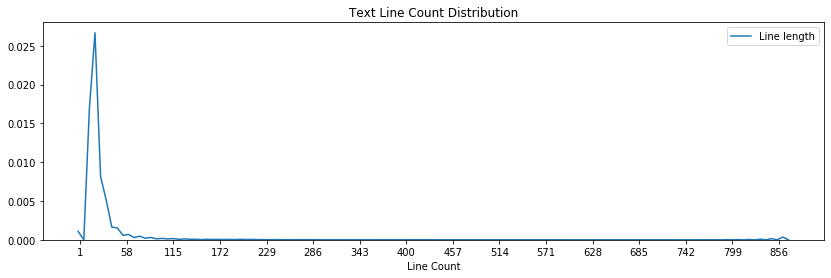

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

line_min = np.min(article_dist['Line length'])
line_max = np.max(article_dist['Line length'])

sns.kdeplot(article_dist['Line length'])

plt.rcParams["figure.figsize"] = (14,4)
plt.title("Text Line Count Distribution")
plt.xticks(np.arange(line_min, line_max, step=int(line_max // 15)), \
           ["{}".format(int(x)) for x in np.arange(line_min, line_max, step=int(line_max // 15))])
plt.xlabel('Line Count')
plt.show()